# Downsample Images

This is more efficient but also leads to better results when predicting images from pixel values

### import packages

In [1]:
import pickle
import json

import re
import glob

import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

### get full data

In [2]:
with open('../data/interim/biggest_Full_flat_df.pkl', 'rb') as fp:
    full_df = pickle.load(fp)

In [3]:
full_df.tail()

0      1      2      3      4      5      \
Surprised Surprised AM32 p228      0      0      0      0      0      0   
                         p230      0      0      0      0      0      0   
                         p231      0      0      0      0      0      0   
                         p232      0      0      0      0      0      0   
                         p233      0      0      0      0      0      0   

                               6      7      8      9      ...  26921  26922  \
Surprised Surprised AM32 p228      0      0      0      0  ...      0      0   
                         p230      0      0      0      0  ...      0      0   
                         p231      0      0      0      0  ...      0      0   
                         p232      0      0      0      0  ...      0      0   
                         p233      0      0      0      0  ...      0      0   

                               26923  26924  26925  26926  26927  26928  \
Surprised Surprised AM32 p228      0      0      0      0      0      0   
                         p230      0      0      0      0      0      0   
                         p231      0      0      0      0      0      0   
                         p232      0      0      0      0      0      0   
                         p233      0      0      0      0      0      0   

                               26929  26930  
Surprised Surprised AM32 p228      0      0  
                         p230      0      0  
                         p231      0      0  
                         p232      0      0  
                         p233      0      0  

[5 rows x 26931 columns]

In [4]:
full_df.shape

(14140, 26931)

### get image dimensions

In [5]:
with open('../data/interim/im_dims.json', 'r') as fp:
    dim_dict = json.load(fp)

n_rows = dim_dict['n_rows']
n_cols = dim_dict['n_cols']
new_n_rows = dim_dict['new_n_rows']
new_n_cols = dim_dict['new_n_cols']
scale_factor = dim_dict['scale_factor']

In [6]:
x_bins = np.array([[i]*scale_factor for i in range(round(n_rows/scale_factor)+scale_factor)]).flatten()[:n_rows]
y_bins = np.array([[i]*scale_factor for i in range(round(n_cols/scale_factor)+scale_factor)]).flatten()[:n_cols]

In [7]:
x_shape, y_shape = np.unique(x_bins).shape[0], np.unique(y_bins).shape[0]
x_shape, y_shape 

(191, 141)

### aggregate all answers

In [8]:
big_im = np.zeros((new_n_rows, new_n_cols ))
for i in tqdm(full_df.index):
    this_data  = full_df.loc[i]
    im = this_data.values.reshape(new_n_rows, new_n_cols )
    big_im += im

  0%|          | 0/14140 [00:00<?, ?it/s]

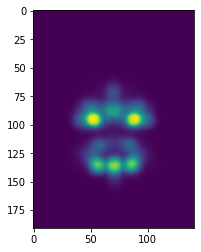

In [9]:
plt.imshow(big_im)

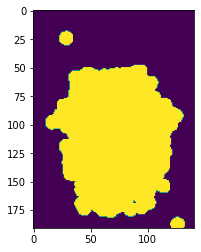

In [10]:
plt.imshow(big_im>0)

### crop to parts where at least two clicks were made

In [11]:
big_im_df = pd.DataFrame(big_im)

In [12]:
new_y = big_im_df.max(axis=1)>1 # more than one, i.e. at least two people had to click there
new_x = big_im_df.max(axis=0)>1

In [13]:
crop_im = big_im_df.loc[new_y, new_x]
crop_im.shape

(132, 110)

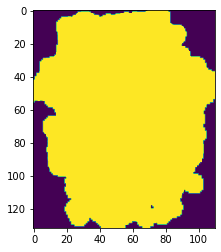

In [14]:
plt.imshow(crop_im, vmin=0, vmax=1)

#### store image and dimensions

In [15]:
crop_im.to_csv('../data/interim/mean_img.tsv', sep='\t')

In [16]:
shape_dict = {'cropped_im': {'y': crop_im.shape[0], 'x': crop_im.shape[1]},
              'cropped_dims': {'y': list(new_y), 'x': list(new_x)}
             }

In [17]:
with open('../data/interim/cropped_im_dims.json', 'w') as fp:
    json.dump(shape_dict, fp)

check if x and y coordinates are consecutive

In [18]:
for n, i in enumerate(crop_im.index):
    if i != crop_im.index[-1]:
        assert crop_im.index[n]+1 == crop_im.index[n+1]
        
for n, i in enumerate(crop_im.columns):
    if i != crop_im.columns[-1]:
        assert crop_im.columns[n]+1 == crop_im.columns[n+1]

### crop image according to new system

In [19]:
def make_cropped_df(full_df, new_n_rows=new_n_rows, new_n_cols=new_n_cols, new_x=new_x, new_y=new_y):
    
    new_df = pd.DataFrame()
    for i in tqdm(full_df.index):

        this_data  = full_df.loc[i]
        im = this_data.values.reshape(new_n_rows, new_n_cols )

        lo_im = pd.DataFrame(im).loc[new_y, new_x]

        new_data = lo_im.values.flatten()
        this_df = pd.DataFrame(new_data).T
        this_df.index = pd.MultiIndex.from_tuples([i])
        new_df = pd.concat([new_df, this_df])
        
    return new_df

### Do this for all masking conditions and store

In [20]:
file_list = glob.glob('../data/interim/biggest_*_flat_df.pkl')
regex = re.compile(r'.*biggest_(\w+)_flat.*')
conds = [regex.findall(i)[-1] for i in file_list]
conds

['Lower', 'Lower_CUTUP', 'Upper', 'Upper_CUTUP', 'Full', 'Full_CUTUP']

In [ ]:
for cond in tqdm(conds):
    with open(f'../data/interim/biggest_{cond}_flat_df.pkl', 'rb') as fp:
        full_df = pickle.load(fp)
    
    new_df = make_cropped_df(full_df)
    new_df.to_csv(f'../data/interim/lofi_{cond}_flat_df.tsv', sep='\t')

### Do this with the version where the clicks into full faces are artificially split into upper/lower

In [22]:
file_list = glob.glob('../data/interim/biggest_*_CUTUP_flat_df.pkl')
regex = re.compile(r'.*biggest_(\w+)_flat.*')
conds = [regex.findall(i)[-1] for i in file_list]
conds

['Lower_CUTUP', 'Upper_CUTUP', 'Full_CUTUP']

In [ ]:
for cond in tqdm(conds):
    
    with open(f'../data/interim/biggest_{cond}_flat_df.pkl', 'rb') as fp:
        full_df = pickle.load(fp)
    
    new_df = make_cropped_df(full_df)
    new_df.to_csv(f'../data/interim/lofi_{cond}_flat_df.tsv', sep='\t')

## Use Pixel Values

In [24]:
stim_df = pd.read_csv('../data/interim/stim_df.tsv', sep='\t', index_col=[0, 1, 2])
stim_df.tail()

file_name    cut
Upper Surprised AM02  ../stim/AM02SUS-MU.jpg  432.0
                AM04  ../stim/AM04SUS-MU.jpg  432.0
                AM06  ../stim/AM06SUS-MU.jpg  432.0
                AM23  ../stim/AM23SUS-MU.jpg  432.0
                AM32  ../stim/AM32SUS-MU.jpg  432.0

In [25]:
def load_im(file_name):
    
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
    
    return img

### store full images

Too large

In [26]:
#img_df = pd.DataFrame()
#
#for i in stim_df.index:
#    im = load_im(stim_df.loc[i, 'file_name'])
#
#    new_data = im.flatten()
#    this_df = pd.DataFrame(new_data).T
#    this_df.index = pd.MultiIndex.from_tuples([i])
#    img_df = pd.concat([img_df, this_df])

In [27]:
#img_df.to_csv('../data/processed/img_full_df.tsv', sep='\t')

### store downsampled

In [28]:
img_df = pd.DataFrame()

for i in stim_df.index:
    im = load_im(stim_df.loc[i, 'file_name'])
    
    new_im = pd.DataFrame(im)

    new_im.index = pd.MultiIndex.from_arrays([x_bins, new_im.index])
    new_im.columns = pd.MultiIndex.from_arrays([y_bins, new_im.columns])
    lo_im = new_im.groupby(level=0, axis=0).max().groupby(level=0, axis=1).max()

    new_data = lo_im.values.flatten()
    this_df = pd.DataFrame(new_data).T
    this_df.index = pd.MultiIndex.from_tuples([i])
    img_df = pd.concat([img_df, this_df])

In [29]:
img_df.to_csv('../data/interim/img_lofi_df.tsv', sep='\t')

### store cropped

In [31]:
new_im

0                   1                   2         ...  138            \
         0    1    2    3    4    5    6    7    8    9    ...  552  553  554   
0   0    243  149  122  142  125  124  141  130  128  128  ...  130  130  130   
    1    148  113  123  142  124  121  132  122  130  129  ...  130  130  130   
    2    124  127  139  138  126  131  141  135  132  131  ...  130  130  130   
    3    135  140  131  119  122  130  131  129  134  132  ...  130  130  130   
1   4    125  130  124  123  134  132  122  124  134  132  ...  130  130  130   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
189 757   73   72   71   71   71   72   72   73   67   67  ...   75   76   78   
    758   67   69   71   72   72   72   72   71   64   66  ...   77   80   82   
    759   62   66   72   75   75   73   71   70   67   70  ...   83   86   87   
190 760   70   71   72   72   71   71   74   76   78   80  ...   67   77   80   
    761   70   71   72   72   71   71   74   76   78   80  ...   68   77   80   

              139                 140       
         555  556  557  558  559  560  561  
0   0    129  129  128  128  128  129  129  
    1    129  129  128  128  128  130  130  
    2    129  129  128  128  128  132  132  
    3    129  129  128  128  128  131  131  
1   4    129  129  128  128  128  131  131  
...      ...  ...  ...  ...  ...  ...  ...  
189 757   81   84   85   83   81   67   67  
    758   83   82   81   80   80   72   72  
    759   85   79   74   73   74   74   74  
190 760   76   75   80   79   74   70   70  
    761   76   75   80   80   74   79   79  

[762 rows x 562 columns]

In [35]:
img_df = pd.DataFrame()

for i in stim_df.index:
    im = load_im(stim_df.loc[i, 'file_name'])
    
    new_im = pd.DataFrame(im)

    new_im.index = pd.MultiIndex.from_arrays([x_bins, new_im.index])
    new_im.columns = pd.MultiIndex.from_arrays([y_bins, new_im.columns])
    lo_im = new_im.groupby(level=0, axis=0).max().groupby(level=0, axis=1).max()
    
    new_im = pd.DataFrame(lo_im).loc[new_y, new_x]
    
    new_data = new_im.values.flatten()
    this_df = pd.DataFrame(new_data).T
    this_df.index = pd.MultiIndex.from_tuples([i])
    img_df = pd.concat([img_df, this_df])

In [36]:
img_df.to_csv('../data/interim/img_cropped_df.tsv', sep='\t')

## mask by area of clicks

In [37]:
img_df = pd.read_csv('../data/interim/img_cropped_df.tsv', sep='\t', index_col=[0, 1, 2])
img_df.tail()

0    1    2    3    4    5    6    7    8    9  ...  \
Upper Surprised AM02  133  132  129  117   32   24   18   23   23   23  ...   
                AM04  141  140  140  145  146  142  141  141  130  106  ...   
                AM06   79   35   20   15   15   12    9   11    9    9  ...   
                AM23  142  144  141  142  142  140  140  143  141  143  ...   
                AM32   65   51   36   57   63   45   27   31   34   28  ...   

                      14510  14511  14512  14513  14514  14515  14516  14517  \
Upper Surprised AM02    255    255    255    255    255    255    255    255   
                AM04    255    255    255    255    255    255    255    255   
                AM06    255    255    255    255    255    255    255    255   
                AM23    255    255    255    255    255    255    255    255   
                AM32    255    255    255    255    255    255    255    255   

                      14518  14519  
Upper Surprised AM02    255    255  
                AM04    255    255  
                AM06    255    255  
                AM23    255    255  
                AM32    255    255  

[5 rows x 14520 columns]

#### Here, a threshold has to be chosen

In [38]:
threshold = 20

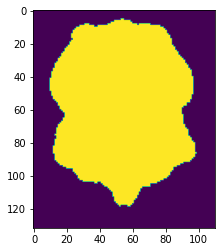

In [39]:
bin_img = crop_im > threshold
plt.imshow(bin_img)

In [40]:
zero_mask = bin_img.values.flatten()

In [41]:
masked_img_df = img_df.T.apply(lambda x:x*zero_mask).T

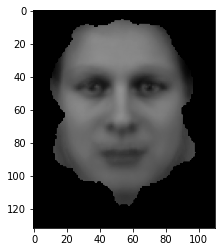

In [42]:
plt.imshow( masked_img_df.mean().values.reshape(bin_img.shape), cmap='Greys_r', vmin=100, vmax=255)

#### Store for re-use

In [43]:
masked_img_df.to_csv('../data/interim/img_masked_df.tsv', sep='\t')